In [24]:
import numpy as np
import tensorflow as tf
import os

np.set_printoptions(precision=2)

### Implementing a CNN in the TensorFlow low-level API

In [2]:
from tensorflow.examples.tutorials import mnist

In [3]:
data = mnist.input_data.read_data_sets(train_dir='MNIST_data/', 
                                       one_hot=True, reshape=False, validation_size=10000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
data.train.num_examples, data.test.num_examples, data.validation.num_examples

(50000, 10000, 10000)

In [5]:
data.train.images.shape, data.train.labels.shape

((50000, 28, 28, 1), (50000, 10))

In [16]:
def conv_layer(input_tensor, kernel_shape, n_out_channels, scope_name, 
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    
    with tf.variable_scope(scope_name):
        m, n1, n2, nc = input_tensor.get_shape().as_list()
        p1, p2 = kernel_shape
        
        kernel = tf.get_variable('kernel', shape=(p1, p2, nc, n_out_channels))
        bias = tf.get_variable('bias', shape=(n_out_channels), initializer=tf.zeros_initializer)
        
        output = tf.nn.conv2d(input_tensor, kernel, padding=padding_mode, strides=strides)
        output = tf.nn.bias_add(output, bias, name='net_input')
        output = tf.nn.relu(output, name='activation')
        return output
    
def fc_layer(input_tensor, n_output, scope_name, activation_func=None):
    with tf.variable_scope(scope_name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        if len(input_shape) > 1:
            # flatten to vector
            n_input = np.prod(input_shape)
            input_tensor = tf.reshape(input_tensor, shape=(-1, n_input))
        else:
            n_input = input_shape[0]
            
        # create W and b
        weight = tf.get_variable('weight', shape=(n_input, n_output))
        bias = tf.get_variable('bias', shape=(n_output), initializer=tf.zeros_initializer)
        
        # operation
        output = tf.nn.bias_add(tf.matmul(input_tensor, weight), bias, name='net_input')
        if activation_func is None:
            return output
        return activation_func(output, name='activation')
    
    
def build_cnn():
    
    # create placeholder for X, Y
    tf_X = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1), name='tf_X')
    tf_Y = tf.placeholder(dtype=tf.float32, shape=(None, 10), name='tf_Y')
    
    # conv_1
    h1 = conv_layer(tf_X, kernel_shape=(5, 5), n_out_channels=32, scope_name='conv1', 
                       padding_mode='SAME', strides=(1,1,1,1))
    # max_pool_1
    h1_maxpool = tf.nn.max_pool(h1, ksize=(1, 2, 2, 1), 
                                strides=(1, 2, 2, 1), padding='VALID')
    # conv_2
    h2 = conv_layer(h1_maxpool, kernel_shape=(5, 5), n_out_channels=64, scope_name='conv2',
                   padding_mode='SAME', strides=(1, 1, 1, 1))
    # max_pool_2
    h2_maxpool = tf.nn.max_pool(h2, ksize=(1, 2, 2, 1), 
                                strides=(1, 2, 2, 1), padding='VALID')
    # fc_1
    h3 = fc_layer(h2_maxpool, n_output=1024, 
                  scope_name='fc1', activation_func=tf.nn.relu)
    # dropout
    dropout = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')
    h3_dropout = tf.nn.dropout(h3, keep_prob=dropout, name='dropout_layer')
    # fc_2
    logits = fc_layer(h3_dropout, n_output=10, 
                      scope_name='fc2', activation_func=None)
    
    # predictions: {probabilities, labels}
    predictions = {
        'probabilities': tf.nn.softmax(logits, name='probabilities'),
        'labels': tf.argmax(logits, axis=1, name='labels')
    }
    # loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=logits), 
                          name='cross_entropy_loss')
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, name='train_op')
    
    # metric: accuracy
    correct_pred = tf.equal(tf.argmax(tf_Y, axis=1), predictions['labels'])
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32), 
                              name='accuracy')
    
def save(saver, sess, epoch, path='./model/'):
    if not os.path.exists(path):
        os.makedirs(path)
    print('Saving model in', path)
    saver.save(sess, save_path=os.path.join(path, 'cnn-model.ckpt'), 
               global_step=epoch)

def load(saver, sess, path, epoch):
    print("Loading model from", path)
    saver.restore(sess, save_path=os.path.join(path, 
                                          'cnn-model.ckpt-{}'.format(epoch)))

def train(sess, training_set, validation_set=None,
          initialize=True, epochs=20, shuffle=True,
          dropout=.5, random_seed=None):
    n_batch = training_set.num_examples // 64 + 1
    
    if initialize:
        sess.run(tf.global_variables_initializer())
    
    training_loss = []
    for i in range(epochs):
        avg_loss = 0.0
        for j in range(n_batch):
            x_batch, y_batch = training_set.next_batch(batch_size=64)
            feed = {'tf_X:0':x_batch, 
                    'tf_Y:0':y_batch, 
                    'keep_prob:0':dropout}
            loss, _ = sess.run(['cross_entropy_loss:0', 'train_op'], feed_dict=feed)
            avg_loss += loss
        training_loss.append(avg_loss / (j+1))
        print("Epoch {}: Training Loss {:.4f}".format(i+1, training_loss[-1]), end=' ')
        
        if validation_set is not None:
            feed = {'tf_X:0': validation_set.images,
                    'tf_Y:0': validation_set.labels,
                    'keep_prob:0': 1.0}
            loss = sess.run('cross_entropy_loss:0', feed_dict=feed)
            print("Validation Loss {:.4f}".format(loss))
        else:
            print()
        
def predict(sess, X_test, return_proba=False):
    feed = {'tf_X:0': X_test.images,
            'tf_Y:0': X_test.labels,
            'keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict=feed)
    return sess.run('labels:0', feed_dict=feed)



### training first time

In [33]:
learning_rate = 1e-4
random_seed = 123
batch_size = 64

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    build_cnn()
    
    #file_writer = tf.summary.FileWriter(logdir='./logs/cnn', graph=g)
    
    saver = tf.train.Saver()

In [34]:
with tf.Session(graph=g) as sess:
    train(sess, data.train, validation_set=data.validation, 
          initialize=True, epochs=20)
    
    save(saver, sess, epoch=20)

Epoch 1: Training Loss 0.3705 Validation Loss 0.1171
Epoch 2: Training Loss 0.1000 Validation Loss 0.0726
Epoch 3: Training Loss 0.0696 Validation Loss 0.0571
Epoch 4: Training Loss 0.0551 Validation Loss 0.0516
Epoch 5: Training Loss 0.0457 Validation Loss 0.0440
Epoch 6: Training Loss 0.0375 Validation Loss 0.0396
Epoch 7: Training Loss 0.0343 Validation Loss 0.0443
Epoch 8: Training Loss 0.0290 Validation Loss 0.0379
Epoch 9: Training Loss 0.0255 Validation Loss 0.0394
Epoch 10: Training Loss 0.0239 Validation Loss 0.0353
Epoch 11: Training Loss 0.0199 Validation Loss 0.0331
Epoch 12: Training Loss 0.0179 Validation Loss 0.0346
Epoch 13: Training Loss 0.0164 Validation Loss 0.0392
Epoch 14: Training Loss 0.0142 Validation Loss 0.0347
Epoch 15: Training Loss 0.0133 Validation Loss 0.0330
Epoch 16: Training Loss 0.0113 Validation Loss 0.0321
Epoch 17: Training Loss 0.0102 Validation Loss 0.0364
Epoch 18: Training Loss 0.0108 Validation Loss 0.0365
Epoch 19: Training Loss 0.0088 Valida

### Calculate prediction accuracy on test set
### restoring the saved model

In [9]:
learning_rate = 1e-4
random_seed = 123
batch_size = 64

# reconstruct the graph
g2 = tf.Graph()
with g2.as_default():
    tf.set_random_seed(random_seed)
    # build graph
    build_cnn()
    
    # saver
    saver = tf.train.Saver()
    

In [19]:
# create a new session and restore the model
with tf.Session(graph=g2) as sess:
    load(saver, sess, path='model/', epoch=20)
    
    preds = predict(sess, data.test, return_proba=False)
    
    print("Test accuracy: {:.2f}%".format(100* np.mean(preds == np.argmax(data.test.labels, axis=1))))

Loading model from model/
INFO:tensorflow:Restoring parameters from model/cnn-model.ckpt-20
Test accuracy: 99.22%


### restore the model and run prediction on some test samples

In [21]:
g2 = tf.Graph()
with g2.as_default():
    build_cnn()
    
    saver = tf.train.Saver()

In [26]:
# load model & run session
with tf.Session(graph=g2) as sess:
    load(saver, sess, path='./model/', epoch=20)
    
    probs = predict(sess, data.test, return_proba=True)
    labels = predict(sess, data.test, return_proba=False)

Loading model from ./model/
INFO:tensorflow:Restoring parameters from ./model/cnn-model.ckpt-20


In [32]:
labels[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [31]:
print(probs[:10].round(2))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Continue training for 20 more epochs using previous model
### save model
### predict on test set

In [ ]:
with tf.Session(graph=g2) as sess:
    
    # load pre-trained model
    load(saver, sess, path='./model/', epoch=20)
    
    # train 20 more epoch
    train(sess, data.train, validation_set=data.validation, 
          initialize=False, epochs=20, dropout=.5)
    
    # save 40-epoch model
    save(saver, sess, epoch=40, path='./model/')
    
    # eval accuracy on test set
    preds = predict(sess, data.test, return_proba=False)
    
    print("test accuracy: {:.2f}%".format(100*np.mean(preds == np.argmax(data.test.labels, axis=1))))

In [37]:
preds

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [38]:
np.mean(np.argmax(data.test.labels, axis=1) == preds) * 100

99.31

### Implementing a CNN in the TensorFlow Layers API

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = input_data.read_data_sets(train_dir='MNIST_data/', validation_size=10000, seed=123)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = data.train.images
y_train = data.train.labels

X_train.shape, y_train.shape

((50000, 784), (50000,))

In [4]:
X_val = data.validation.images
y_val = data.validation.labels

X_val.shape, y_val.shape

((10000, 784), (10000,))

In [5]:
X_test = data.test.images
y_test = data.test.labels

X_test.shape, y_test.shape

((10000, 784), (10000,))

In [21]:
class ConvNN:
    '''a convolutional neural networks model'''
    def __init__(self, batch_size=64, learning_rate=1e-4, 
                 drop_out=.5, epochs=20, random_state=None, 
                 shuffle=True):
        # hyperparameters
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.drop_out = drop_out
        self.epochs = epochs
        self.random_state = random_state
        self.shuffle = shuffle
        
        # graph model
        g = tf.Graph()
        with g.as_default():
            # set random state
            tf.set_random_seed(self.random_state)
            
            # build graph
            self.build()
            
            # init global variabels
            self.init_op = tf.global_variables_initializer()
            
            # create saver
            self.saver = tf.train.Saver()
        
        # graph session
        self.sess = tf.Session(graph=g)
            
    def build(self):
        '''construct CNN layers'''
        tf_X = tf.placeholder(dtype=tf.float32, shape=(None, 784), name='tf_X')
        tf_Y = tf.placeholder(dtype=tf.int32, shape=(None),name='tf_Y')
        is_train = tf.placeholder(dtype=tf.bool, shape=(), name='is_train')
        
        # preprocessing Input & Output
        tf_X_images = tf.reshape(tf_X, shape=(-1, 28, 28, 1), name='tf_X_2d')
        tf_Y_onehot = tf.one_hot(tf_Y, depth=10, axis=1, name='tf_Y_onehot')
        
        # conv-1
        h1 = tf.layers.conv2d(tf_X_images, filters=32, kernel_size=(5, 5), 
                              strides=(1, 1), padding='SAME', activation=tf.nn.relu)
        
        h1_pool = tf.layers.max_pooling2d(h1, pool_size=(2, 2), 
                                          strides=(2,2), padding='valid')
        # conv-2
        h2 = tf.layers.conv2d(h1_pool, filters=64, kernel_size=(5, 5), padding='SAME', 
                              strides=(1, 1), activation=tf.nn.relu)
        
        h2_pool = tf.layers.max_pooling2d(h2, pool_size=(2, 2), 
                                          strides=(2, 2), padding='valid')
        
        h2_flat = tf.layers.flatten(h2_pool)
        
        # fc-1
        h3 = tf.layers.dense(h2_flat, units=1024, use_bias=True, activation=tf.nn.relu)
        # drop out
        h3_drop = tf.layers.dropout(h3, rate=self.drop_out, training=is_train)
        
        # fc-2
        h4 = tf.layers.dense(h3_drop, units=10, use_bias=True, activation=None)
        
        # outcomes
        predictions = {
            'probabilities': tf.nn.softmax(logits=h4, axis=1, name='probabilities'),
            'labels': tf.argmax(h4, axis=1, output_type=tf.int32, name='labels')
        }
        
        # cost function
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=h4, labels=tf_Y_onehot), 
                             name='cross_entropy_loss')
        
        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        optimizer = optimizer.minimize(loss, name='train_op')
        
        # evaluate accuracy
        accuracy = tf.reduce_mean(
                        tf.cast(tf.equal(predictions['labels'], tf_Y), dtype=tf.float32),
                        name='accuracy'
                    )
        
    def train(self, train_set, validation_set=None, initialize=True):
        
        if initialize:
            self.sess.run(self.init_op)
        
        self.train_costs_ = []
        X_train = np.array(train_set[0])
        y_train = np.array(train_set[1])
        for i in range(self.epochs):
            avg_loss = 0.0
            for j, (x_batch, y_batch) in enumerate(ConvNN.next_batch(X_train, y_train, shuffle=self.shuffle)):
                feed = {'tf_X:0': x_batch, 'tf_Y:0': y_batch, 'is_train:0': True}
                _, c = self.sess.run(['train_op', 'cross_entropy_loss:0'], 
                                     feed_dict=feed)
                avg_loss += c
            self.train_costs_.append(avg_loss/(j+1))
            print("Epoch {:3d}: Training Avg. Loss: {:.4f}".format(i+1, self.train_costs_[-1]), end=' ')
            # 1 epoch pass
            if validation_set is not None:
                X_val = np.array(validation_set[0])
                y_val = np.array(validation_set[1])
                feed = {'tf_X:0': X_val, 'tf_Y:0':y_val, 'is_train:0': False}
                c, acc = self.sess.run(['cross_entropy_loss:0', 'accuracy:0'], feed_dict=feed)
                print(", Validation Loss: {:.4f}, Validation accuracy: {:.3f}".format(c, acc))
            else:
                print()
        
    def predict(self, X_test, reture_prob=False):
        feed = {'tf_X:0': X_test, 'is_train:0': False}
        if reture_prob:
            return self.sess.run('probabilities:0', feed_dict=feed)
        return self.sess.run('labels:0', feed_dict=feed)
    
    def save(self, epoch, path='./tflayers-model/'):
        if not os.path.exists(path):
            os.makedirs(path)
        print("Saving model in {}".format(path))
        self.saver.save(self.sess, 
                        os.path.join(path, 'model.ckpt'), 
                        global_step=epoch)
        
    def load(self, epoch, path='./tflayers-model/'):
        print("Loading model from {}".format(path))
        self.saver.restore(self.sess, 
                           os.path.join(path, 'model.ckpt-{}'.format(epoch)))
        
    @staticmethod
    def next_batch(X, y, shuffle=True, batch_size=32):
        n_batch = len(X) // batch_size + 1
        if shuffle:
            idx = np.random.permutation(range(len(X)))
        else:
            idx = np.arange(0, len(X))
        
        for i in range(n_batch):
            a, b = i*batch_size, (i+1)*batch_size
            
            yield X[idx[a:b]], y[idx[a:b]]

#### train first time and save model

In [22]:
cnn = ConvNN(batch_size=32, learning_rate=.0001, 
           drop_out=.5, epochs=20, random_state=42, shuffle=True)

In [23]:
cnn.train(train_set=(X_train, y_train), 
          validation_set=(X_val, y_val), 
          initialize=True)

Epoch   1: Training Avg. Loss: 0.2814 Validation Loss: 0.0958, Validation accuracy: 0.973
Epoch   2: Training Avg. Loss: 0.0804 Validation Loss: 0.0622, Validation accuracy: 0.982
Epoch   3: Training Avg. Loss: 0.0570 Validation Loss: 0.0510, Validation accuracy: 0.984
Epoch   4: Training Avg. Loss: 0.0436 Validation Loss: 0.0432, Validation accuracy: 0.987
Epoch   5: Training Avg. Loss: 0.0370 Validation Loss: 0.0392, Validation accuracy: 0.989
Epoch   6: Training Avg. Loss: 0.0303 Validation Loss: 0.0359, Validation accuracy: 0.990
Epoch   7: Training Avg. Loss: 0.0259 Validation Loss: 0.0374, Validation accuracy: 0.990
Epoch   8: Training Avg. Loss: 0.0217 Validation Loss: 0.0349, Validation accuracy: 0.990
Epoch   9: Training Avg. Loss: 0.0190 Validation Loss: 0.0329, Validation accuracy: 0.990
Epoch  10: Training Avg. Loss: 0.0157 Validation Loss: 0.0332, Validation accuracy: 0.989
Epoch  11: Training Avg. Loss: 0.0158 Validation Loss: 0.0338, Validation accuracy: 0.990
Epoch  12:

In [24]:
cnn.save(epoch=20)

Saving model in ./tflayers-model/


#### load model and predict on test set

In [25]:
del cnn

In [26]:
cnn = ConvNN(batch_size=32, random_state=42)

In [27]:
cnn.load(epoch=20)

Loading model from ./tflayers-model/
INFO:tensorflow:Restoring parameters from ./tflayers-model/model.ckpt-20


In [38]:
print('Test accuracy: {:.2f}%'.format(100*np.mean(y_pred==y_test)))

Test accuracy: 99.39%


In [28]:
y_pred = cnn.predict(X_test)

In [29]:
y_pred[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [30]:
miss_idx = y_pred != y_test

In [31]:
miss_idx.sum()

61

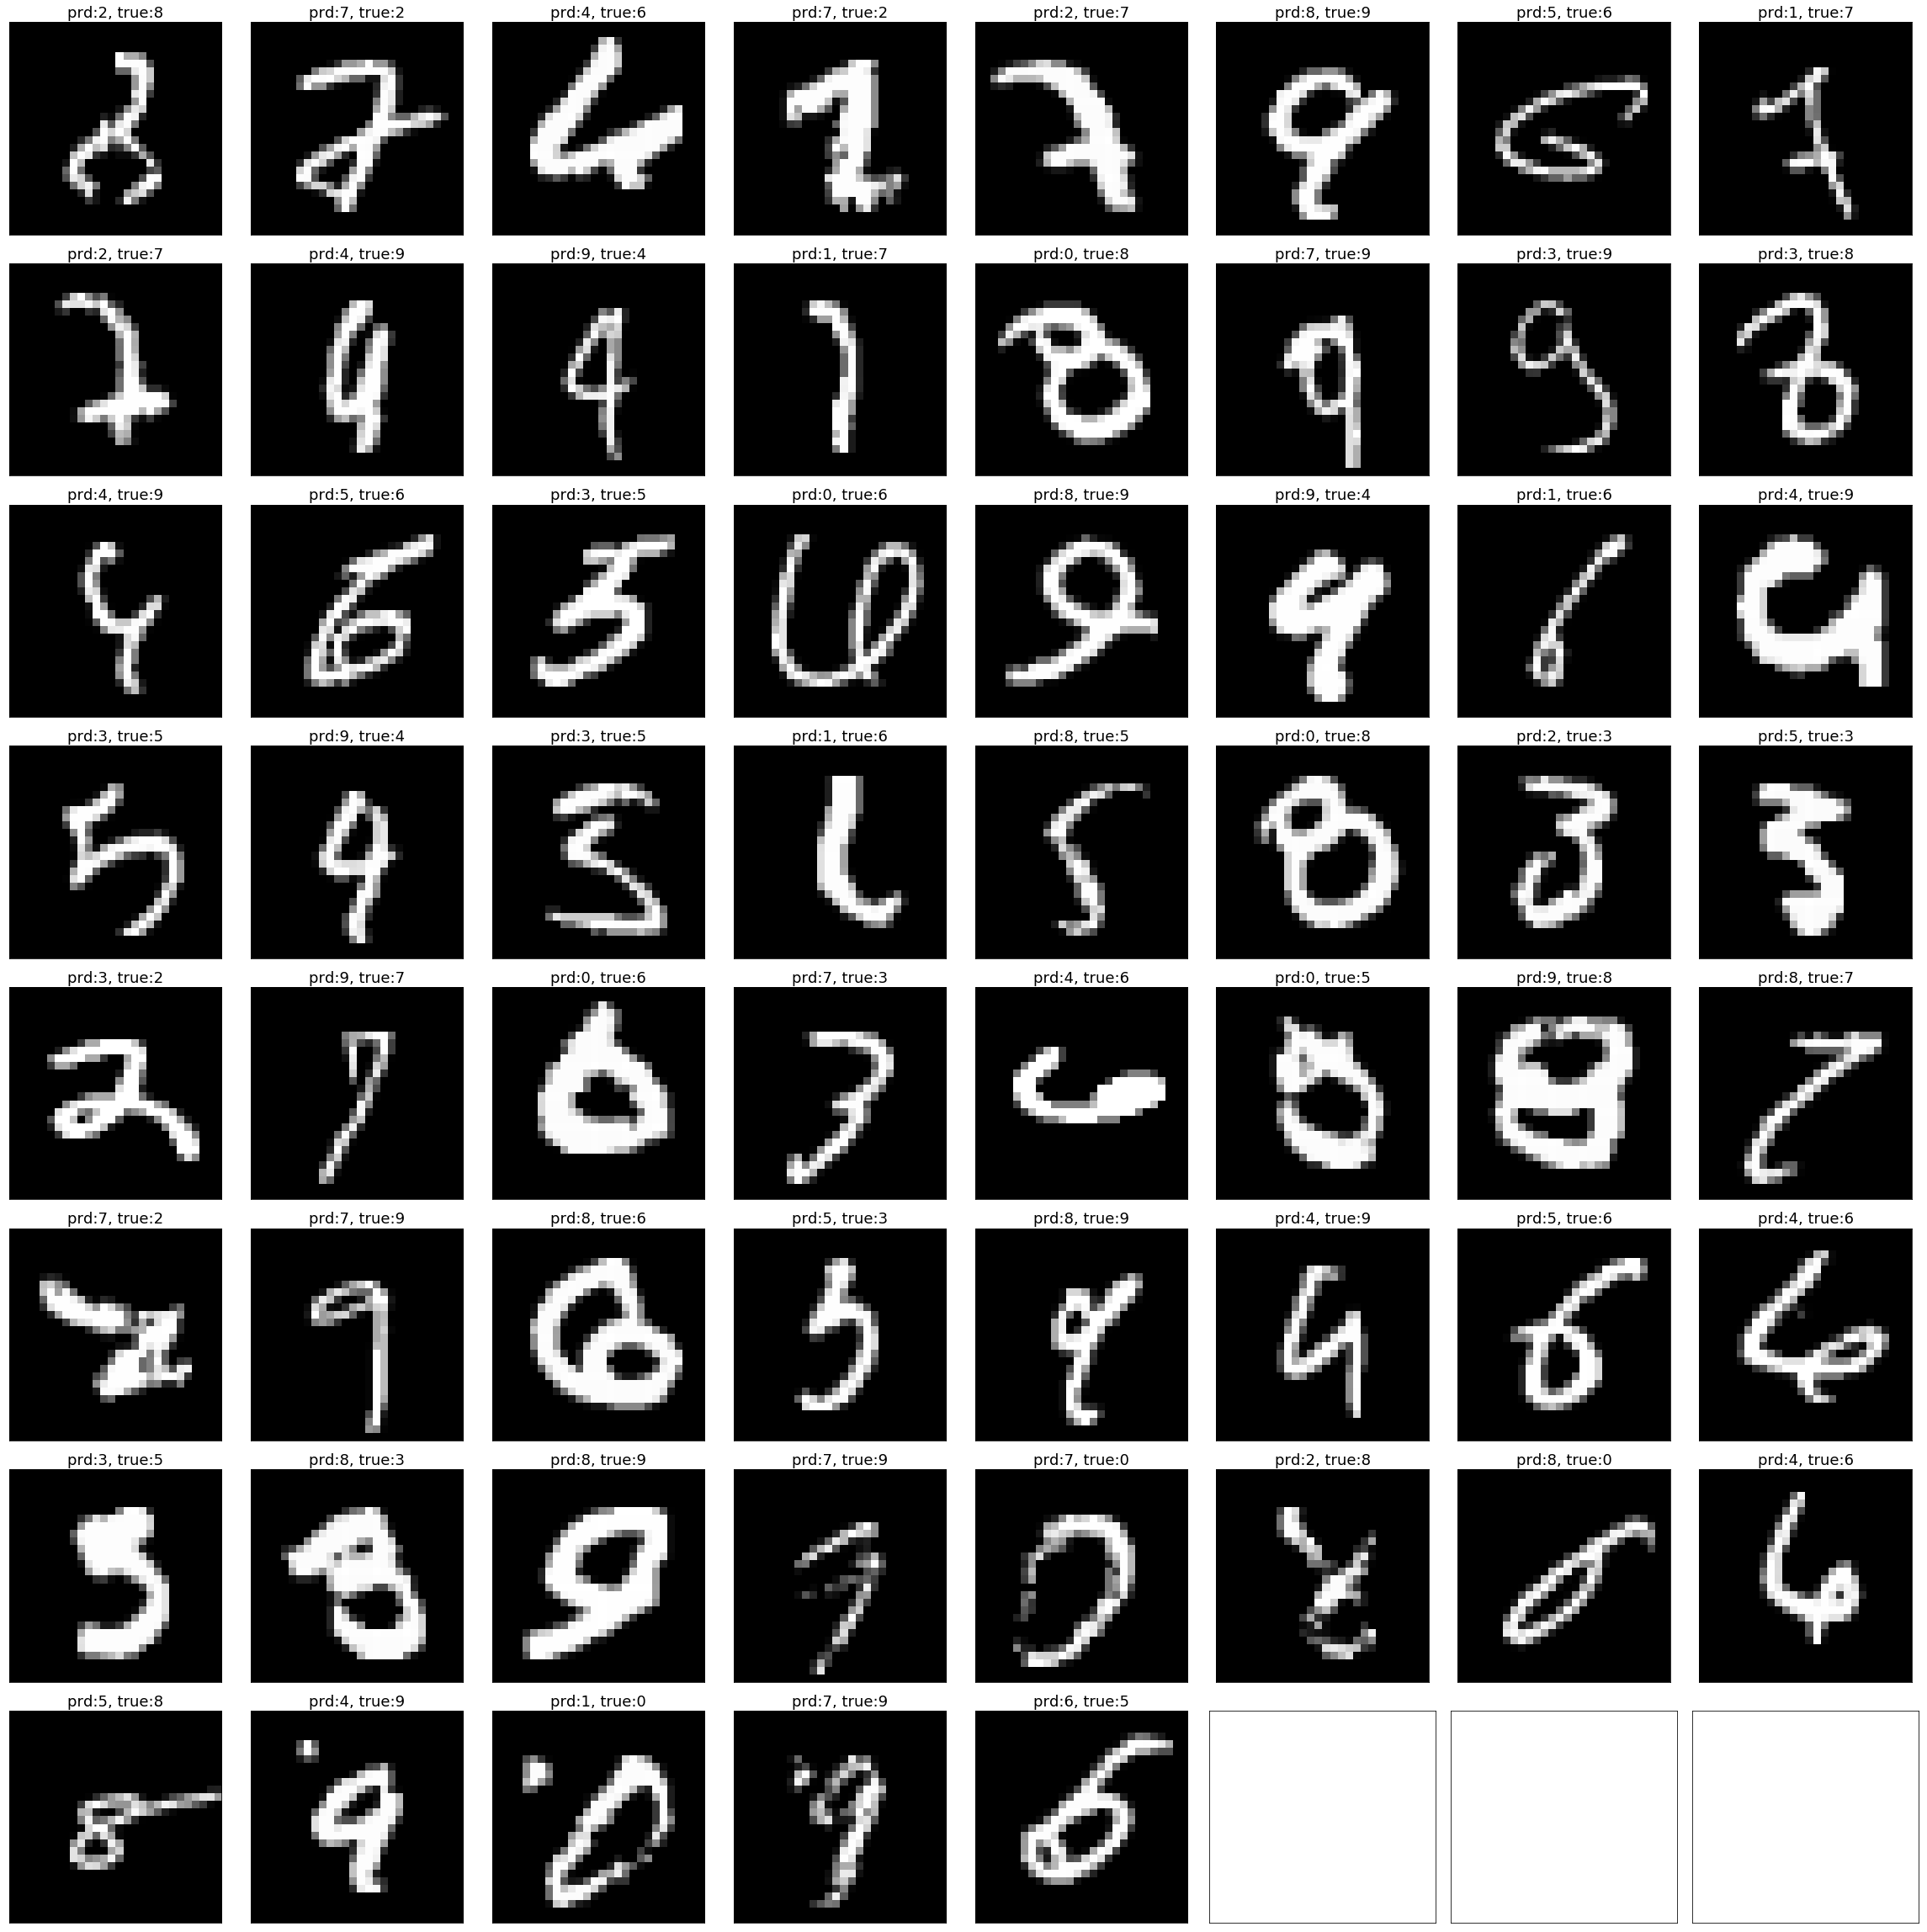

In [37]:
y_pred_miss = y_pred[miss_idx]
y_true_miss = y_test[miss_idx]

fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(32, 32), 
                       subplot_kw={'xticks':[], 'yticks':[]})
for im, axi, pred_, true_ in zip(X_test[miss_idx], ax.flat, 
                                 y_pred_miss, y_true_miss):
    im = im.reshape(28, 28)
    axi.imshow(im, cmap=plt.cm.gray)
    axi.set_title("prd:{}, true:{}".format(pred_, true_), fontdict={'fontsize':18})

fig.tight_layout()